In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 47535880.000000, Accuracy = 0.00200000009499
Performance on test set: Training epochs #1000, Batch Loss = 26024720.0, Accuracy = 0.00200000009499
Training epochs #20000: Batch Loss = 24588608.000000, Accuracy = 0.097999997437
Performance on test set: Training epochs #20000, Batch Loss = 9268202.0, Accuracy = 0.0120000001043
Training epochs #40000: Batch Loss = 7712641.000000, Accuracy = 0.217999994755
Performance on test set: Training epochs #40000, Batch Loss = 1797278.25, Accuracy = 0.805000007153
Training epochs #60000: Batch Loss = 4656694.000000, Accuracy = 0.570999979973
Performance on test set: Training epochs #60000, Batch Loss = 2723108.25, Accuracy = 0.805000007153
Training epochs #80000: Batch Loss = 3135582.500000, Accuracy = 0.697000026703
Performance on test set: Training epochs #80000, Batch Loss = 2683450.25, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 19308900.000000, Accuracy = 0.0439999997616
Performance on test

Training epochs #920000: Batch Loss = 681910.750000, Accuracy = 0.746999979019
Performance on test set: Training epochs #920000, Batch Loss = 132136.3125, Accuracy = 0.943000078201
Training epochs #940000: Batch Loss = 491639.718750, Accuracy = 0.85900002718
Performance on test set: Training epochs #940000, Batch Loss = 216417.3125, Accuracy = 0.942999958992
Training epochs #960000: Batch Loss = 401293.500000, Accuracy = 0.884999990463
Performance on test set: Training epochs #960000, Batch Loss = 248749.125, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 3683764.750000, Accuracy = 0.266999989748
Performance on test set: Training epochs #980000, Batch Loss = 98453.859375, Accuracy = 0.949000000954
Training epochs #1000000: Batch Loss = 727751.750000, Accuracy = 0.748000025749
Performance on test set: Training epochs #1000000, Batch Loss = 120319.296875, Accuracy = 0.949000000954
Training epochs #1020000: Batch Loss = 482139.656250, Accuracy = 0.858000040054
Performance

Training epochs #1820000: Batch Loss = 226504.390625, Accuracy = 0.895000040531
Performance on test set: Training epochs #1820000, Batch Loss = 91776.8203125, Accuracy = 0.960999965668
Training epochs #1840000: Batch Loss = 124122.078125, Accuracy = 0.928000032902
Performance on test set: Training epochs #1840000, Batch Loss = 100339.429688, Accuracy = 0.955000042915
Training epochs #1860000: Batch Loss = 1862372.000000, Accuracy = 0.366999983788
Performance on test set: Training epochs #1860000, Batch Loss = 51374.4570312, Accuracy = 0.962000012398
Training epochs #1880000: Batch Loss = 285745.593750, Accuracy = 0.837000012398
Performance on test set: Training epochs #1880000, Batch Loss = 69715.453125, Accuracy = 0.961000025272
Training epochs #1900000: Batch Loss = 216579.562500, Accuracy = 0.898000061512
Performance on test set: Training epochs #1900000, Batch Loss = 86872.421875, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 165051.406250, Accuracy = 0.928000032

Training epochs #2720000: Batch Loss = 81529.960938, Accuracy = 0.93599998951
Performance on test set: Training epochs #2720000, Batch Loss = 53252.65625, Accuracy = 0.961000025272
Training epochs #2740000: Batch Loss = 918771.125000, Accuracy = 0.481000006199
Performance on test set: Training epochs #2740000, Batch Loss = 21753.328125, Accuracy = 0.989000082016
Training epochs #2760000: Batch Loss = 136759.500000, Accuracy = 0.907000005245
Performance on test set: Training epochs #2760000, Batch Loss = 42569.84375, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 123258.062500, Accuracy = 0.921000003815
Performance on test set: Training epochs #2780000, Batch Loss = 49950.8203125, Accuracy = 0.961000025272
Training epochs #2800000: Batch Loss = 68714.460938, Accuracy = 0.947000086308
Performance on test set: Training epochs #2800000, Batch Loss = 50709.5546875, Accuracy = 0.961000025272
Training epochs #2820000: Batch Loss = 872542.937500, Accuracy = 0.522000014782
Per

Training epochs #3620000: Batch Loss = 511697.187500, Accuracy = 0.59399998188
Performance on test set: Training epochs #3620000, Batch Loss = 12829.4501953, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 65275.835938, Accuracy = 0.927999973297
Performance on test set: Training epochs #3640000, Batch Loss = 18373.8164062, Accuracy = 0.967999994755
Training epochs #3660000: Batch Loss = 41002.781250, Accuracy = 0.956000030041
Performance on test set: Training epochs #3660000, Batch Loss = 17755.1855469, Accuracy = 0.961000025272
Training epochs #3680000: Batch Loss = 24971.078125, Accuracy = 0.967000007629
Performance on test set: Training epochs #3680000, Batch Loss = 15555.8076172, Accuracy = 0.961000025272
Training epochs #3700000: Batch Loss = 538322.875000, Accuracy = 0.59399998188
Performance on test set: Training epochs #3700000, Batch Loss = 12861.4238281, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 55840.695312, Accuracy = 0.93599998951
Pe

Training epochs #4520000: Batch Loss = 31095.406250, Accuracy = 0.958999991417
Performance on test set: Training epochs #4520000, Batch Loss = 4494.15234375, Accuracy = 0.975999951363
Training epochs #4540000: Batch Loss = 34724.160156, Accuracy = 0.958000063896
Performance on test set: Training epochs #4540000, Batch Loss = 2611.56542969, Accuracy = 0.977000057697
Training epochs #4560000: Batch Loss = 16737.576172, Accuracy = 0.972999989986
Performance on test set: Training epochs #4560000, Batch Loss = 1405.05249023, Accuracy = 0.985000014305
Training epochs #4580000: Batch Loss = 305500.343750, Accuracy = 0.692999958992
Performance on test set: Training epochs #4580000, Batch Loss = 7995.13867188, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 38650.507812, Accuracy = 0.952000021935
Performance on test set: Training epochs #4600000, Batch Loss = 5572.77636719, Accuracy = 0.975999951363
Training epochs #4620000: Batch Loss = 32380.126953, Accuracy = 0.958999991417


Training epochs #5420000: Batch Loss = 30357.621094, Accuracy = 0.968000054359
Performance on test set: Training epochs #5420000, Batch Loss = 603.440795898, Accuracy = 0.990999996662
Training epochs #5440000: Batch Loss = 5137.268066, Accuracy = 0.983000040054
Performance on test set: Training epochs #5440000, Batch Loss = 370.006011963, Accuracy = 0.999000072479
Training epochs #5460000: Batch Loss = 207199.218750, Accuracy = 0.741999983788
Performance on test set: Training epochs #5460000, Batch Loss = 5688.30273438, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 14480.163086, Accuracy = 0.967000067234
Performance on test set: Training epochs #5480000, Batch Loss = 46.7166290283, Accuracy = 0.999000072479
Training epochs #5500000: Batch Loss = 25327.736328, Accuracy = 0.967000007629
Performance on test set: Training epochs #5500000, Batch Loss = 393.430511475, Accuracy = 0.999000072479
Training epochs #5520000: Batch Loss = 7379.098633, Accuracy = 0.981000065804
Pe

Training epochs #6340000: Batch Loss = 114348.390625, Accuracy = 0.81500005722
Performance on test set: Training epochs #6340000, Batch Loss = 2636.47265625, Accuracy = 0.991000056267
Training epochs #6360000: Batch Loss = 4319.220215, Accuracy = 0.982000052929
Performance on test set: Training epochs #6360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6380000: Batch Loss = 8210.828125, Accuracy = 0.981000065804
Performance on test set: Training epochs #6380000, Batch Loss = 207.21963501, Accuracy = 0.999000072479
Training epochs #6400000: Batch Loss = 3435.756348, Accuracy = 0.990999937057
Performance on test set: Training epochs #6400000, Batch Loss = 53.6656265259, Accuracy = 0.999000072479
Training epochs #6420000: Batch Loss = 106845.398438, Accuracy = 0.820999979973
Performance on test set: Training epochs #6420000, Batch Loss = 2135.76757812, Accuracy = 0.991000056267
Training epochs #6440000: Batch Loss = 11656.894531, Accuracy = 0.970999956131
Performance on 

Training epochs #7280000: Batch Loss = 751.080139, Accuracy = 0.994000077248
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7300000: Batch Loss = 62505.156250, Accuracy = 0.871000051498
Performance on test set: Training epochs #7300000, Batch Loss = 1254.19030762, Accuracy = 0.996999979019
Training epochs #7320000: Batch Loss = 3087.359863, Accuracy = 0.984999895096
Performance on test set: Training epochs #7320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7340000: Batch Loss = 4182.233398, Accuracy = 0.98299998045
Performance on test set: Training epochs #7340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7360000: Batch Loss = 2357.002930, Accuracy = 0.993000090122
Performance on test set: Training epochs #7360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7380000: Batch Loss = 66681.312500, Accuracy = 0.85900002718
Performance on test set: Training epochs #7380000, B

Training epochs #8220000: Batch Loss = 2229.995361, Accuracy = 0.992999970913
Performance on test set: Training epochs #8220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8240000: Batch Loss = 855.847534, Accuracy = 0.995000064373
Performance on test set: Training epochs #8240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8260000: Batch Loss = 39707.269531, Accuracy = 0.891000032425
Performance on test set: Training epochs #8260000, Batch Loss = 578.238220215, Accuracy = 0.996999979019
Training epochs #8280000: Batch Loss = 4393.611328, Accuracy = 0.983000040054
Performance on test set: Training epochs #8280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8300000: Batch Loss = 2380.656738, Accuracy = 0.988999962807
Performance on test set: Training epochs #8300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8320000: Batch Loss = 507.291046, Accuracy = 0.996000051498
Performance on test set: Training epochs #8320000, B

Training epochs #9160000: Batch Loss = 1877.826538, Accuracy = 0.987999916077
Performance on test set: Training epochs #9160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9180000: Batch Loss = 2254.931641, Accuracy = 0.995000004768
Performance on test set: Training epochs #9180000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #9200000: Batch Loss = 1101.956543, Accuracy = 0.996000051498
Performance on test set: Training epochs #9200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9220000: Batch Loss = 25793.994141, Accuracy = 0.925999999046
Performance on test set: Training epochs #9220000, Batch Loss = 417.426330566, Accuracy = 0.996999979019
Training epochs #9240000: Batch Loss = 2362.758057, Accuracy = 0.989999949932
Performance on test set: Training epochs #9240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9260000: Batch Loss = 1852.604248, Accuracy = 0.993000030518
Performance on test set: Training epochs #9260000, Batch Los

Training epochs #10120000: Batch Loss = 117.187195, Accuracy = 0.999000072479
Performance on test set: Training epochs #10120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10140000: Batch Loss = 1038.639648, Accuracy = 0.995000004768
Performance on test set: Training epochs #10140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10160000: Batch Loss = 460.306915, Accuracy = 0.998000025749
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10180000: Batch Loss = 15643.120117, Accuracy = 0.94000005722
Performance on test set: Training epochs #10180000, Batch Loss = 79.2735977173, Accuracy = 0.997000098228
Training epochs #10200000: Batch Loss = 866.766724, Accuracy = 0.990999996662
Performance on test set: Training epochs #10200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10220000: Batch Loss = 975.938049, Accuracy = 0.996000051498
Performance on test set: Training epochs #10

Training epochs #11060000: Batch Loss = 8302.438477, Accuracy = 0.956000089645
Performance on test set: Training epochs #11060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11080000: Batch Loss = 1130.997559, Accuracy = 0.995000004768
Performance on test set: Training epochs #11080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11100000: Batch Loss = 623.579590, Accuracy = 0.997000098228
Performance on test set: Training epochs #11100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11120000: Batch Loss = 4.495625, Accuracy = 0.999000072479
Performance on test set: Training epochs #11120000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11140000: Batch Loss = 11310.084961, Accuracy = 0.942999958992
Performance on test set: Training epochs #11140000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11160000: Batch Loss = 352.241943, Accuracy = 0.997000038624
Performance on test set: Training epochs #11160000, Batch Loss = 0.0, Accur

Training epochs #12020000: Batch Loss = 8988.037109, Accuracy = 0.949000060558
Performance on test set: Training epochs #12020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12040000: Batch Loss = 111.641823, Accuracy = 0.998000085354
Performance on test set: Training epochs #12040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12060000: Batch Loss = 284.714600, Accuracy = 0.996999979019
Performance on test set: Training epochs #12060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12080000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #12080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12100000: Batch Loss = 6563.385254, Accuracy = 0.967000067234
Performance on test set: Training epochs #12100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12120000: Batch Loss = 606.926208, Accuracy = 0.996000051498
Performance on test set: Training epochs #12120000, Batch 

Training epochs #12980000: Batch Loss = 5599.366211, Accuracy = 0.956000089645
Performance on test set: Training epochs #12980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13000000: Batch Loss = 1438.452271, Accuracy = 0.991999983788
Performance on test set: Training epochs #13000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13020000: Batch Loss = 116.253288, Accuracy = 0.999000072479
Performance on test set: Training epochs #13020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13040000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13060000: Batch Loss = 2920.636963, Accuracy = 0.978999972343
Performance on test set: Training epochs #13060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13080000: Batch Loss = 842.546509, Accuracy = 0.993000030518
Performance on test set: Training epochs #13080000, Batch

Training epochs #13940000: Batch Loss = 4021.384521, Accuracy = 0.962999999523
Performance on test set: Training epochs #13940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13960000: Batch Loss = 268.794006, Accuracy = 0.994000017643
Performance on test set: Training epochs #13960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13980000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14000000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 3928.685547, Accuracy = 0.966000080109
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 179.870819, Accuracy = 0.995999991894
Performance on test set: Training epochs #14040000, Batch Los

Training epochs #14900000: Batch Loss = 1174.939575, Accuracy = 0.98400002718
Performance on test set: Training epochs #14900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14920000: Batch Loss = 536.350220, Accuracy = 0.994000077248
Performance on test set: Training epochs #14920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14940000: Batch Loss = 144.554489, Accuracy = 0.996999979019
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14980000: Batch Loss = 2886.694824, Accuracy = 0.978000044823
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15000000: Batch Loss = 193.420135, Accuracy = 0.997000098228
Performance on test set: Training epochs #15000000, Batch L

Training epochs #15860000: Batch Loss = 2257.773926, Accuracy = 0.985999941826
Performance on test set: Training epochs #15860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15880000: Batch Loss = 43.671871, Accuracy = 0.998000085354
Performance on test set: Training epochs #15880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15900000: Batch Loss = 0.000000, Accuracy = 1.0
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15940000: Batch Loss = 2487.884033, Accuracy = 0.976000010967
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15960000: Batch Loss = 7.175188, Accuracy = 0.999000072479
Performance on test set: Training epochs #15960000, Batch Loss = 0.0, Accuracy = 1.00000011921

# performance visualization

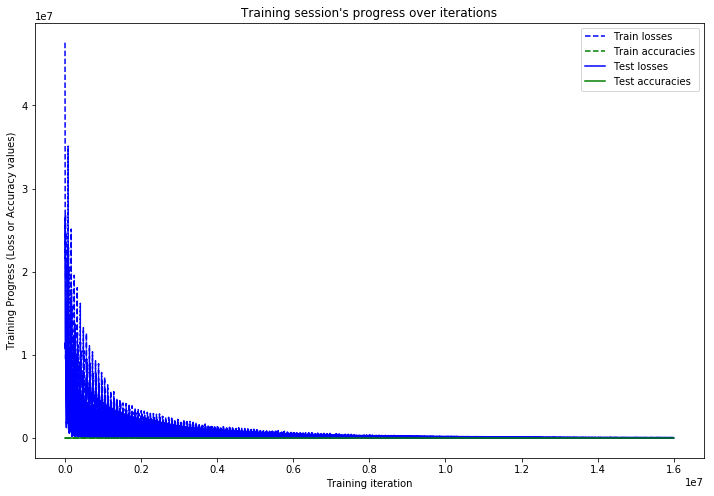

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.7713562889%
Recall: 97.71%
f1_score: 97.6318941994%

Confusion Matrix:
[[    0     3     0     0     0     5     0    10     0     0     0     0
      0]
 [    6   797    26     0    27    24    21     4     5     0     0     1
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0  2865    10     0    11     0     0     0     3
      0]
 [    0    26     1     0     2   319     0     0     0     0     0     0
      0]
 [    0     7     2     0     0     0 14486     0     0     0     0     0
      0]
 [    0    66    16     0    39    36     5   372     0     0     0     1
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     2     0     0     0     0     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


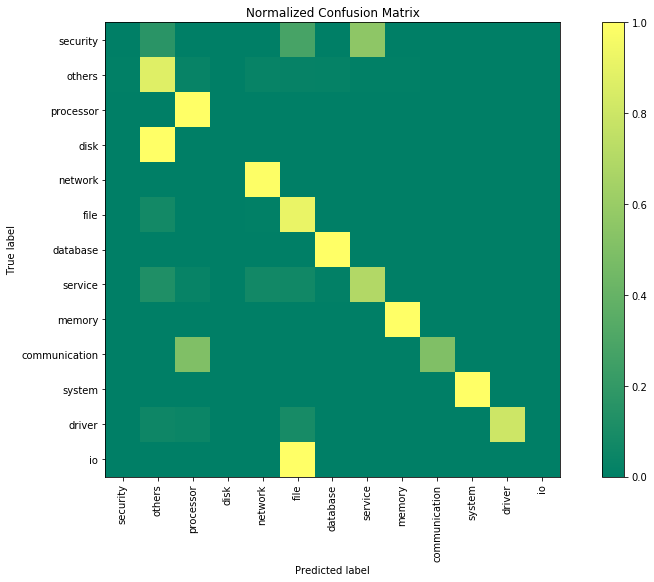

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)